# Processing and Plotting SeaBASS (.sb) Files

This notebook contains a workflow for reading multiple SeaBASS (`.sb`) files from a folder, combining them, subsetting the data by date and station, and then plotting specific parameters.

We will use:
* `SB_support.py` (the provided module) to read the files.
* `pandas` to aggregate and filter the data.
* `matplotlib` to plot the results.

# Workflow:

The notebook:
1.  Loads all `.sb` files from the target directory.
2.  Parses them using the `readSB` class.
3.  Combines them into a single `pandas.DataFrame`.
4.  Filteres the data based on your specified `station` and `datetime` range.
5.  Plots the requested parameters (`ag`, `ap`, `ad`) over time.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re  # Import regular expressions
import folium # The new mapping library

# Import the readSB class from the local .py file
try:
    from SB_support import readSB
    print("SB_support module loaded successfully.")
except ImportError:
    print("ERROR: Could not find SB_support.py.")
    print("Please make sure SB_support.py is in the same directory as this notebook.")

# Set up plotting style
plt.style.use('ggplot')
%matplotlib inline

SB_support module loaded successfully.


### Read the .sb file and Plot Spectral Data (Wavelength vs. Parameter)

SB_support module loaded successfully.

Reading file: seabass_data/fb7c68e905_SFMBON_WS25130_ag_10_2m_030_202505152303_R1.sb...

--- Extracted Metadata ---
Station ID: 10
Coordinates: 24.7883, -80.86
Datetime: 2025-05-15 23:03:00

Found parameter 'ag' to plot.
Plotting data...


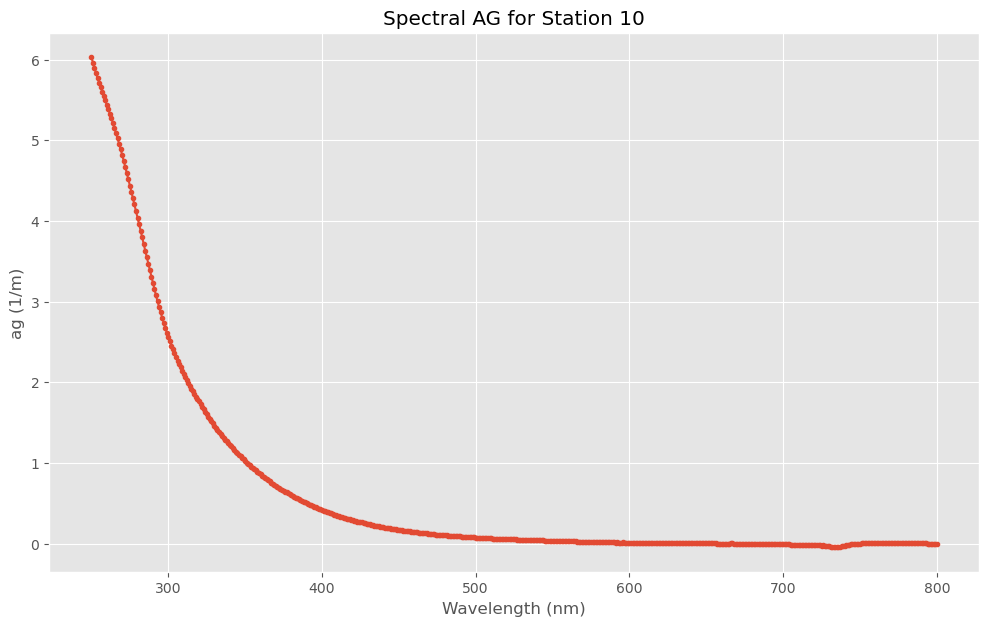

In [2]:
# --- Import the readSB class ---
try:
    from SB_support import readSB
    print("SB_support module loaded successfully.")
except ImportError:
    print("ERROR: Could not find SB_support.py.")
    print("Please make sure SB_support.py is in the same directory as this notebook.")
    # Stop execution if module is missing
    raise

# --- Configuration ---
DATA_FOLDER = 'seabass_data' 
FILE_TO_READ = 'fb7c68e905_SFMBON_WS25130_ag_10_2m_030_202505152303_R1.sb'
PARAMS_TO_PLOT = ['ag', 'ap', 'ad']
# ---------------------

# --- Variable Placeholders ---
# We define these here so they are available for the next cell
station_id = 'Unknown'
param_found = None
lat_float = None
lon_float = None
# -----------------------------

file_path = os.path.join(DATA_FOLDER, FILE_TO_READ)

if not os.path.exists(file_path):
    print(f"\nERROR: File not found at: {file_path}")
else:
    try:
        # 1. Read file
        print(f"\nReading file: {file_path}...")
        sb_data = readSB(filename=file_path, no_warn=True)

        # 2. Extract and store metadata
        print("\n--- Extracted Metadata ---")
        station_id = sb_data.headers.get('station', 'Unknown')
        print(f"Station ID: {station_id}")

        # Get coord strings and parse them into floats
        lat_str = sb_data.headers.get('north_latitude', 'Not Found')
        lon_str = sb_data.headers.get('east_longitude', 'Not Found')
        
        try:
            lat_float = float(lat_str.replace('[DEG]', ''))
            lon_float = float(lon_str.replace('[DEG]', ''))
            print(f"Coordinates: {lat_float}, {lon_float}")
        except (ValueError, AttributeError):
            print(f"Warning: Could not parse coordinates: {lat_str}, {lon_str}")

        # 3. Extract datetimes
        datetimes_list = sb_data.fd_datetime()
        if datetimes_list:
            print(f"Datetime: {datetimes_list[0]}")
        
        # 4. Find parameter and plot
        df = pd.DataFrame(sb_data.data)
        if 'wavelength' not in df.columns:
            print("\nERROR: File does not contain a 'wavelength' data column.")
        else:
            for param in PARAMS_TO_PLOT:
                if param in df.columns:
                    param_found = param # This is the 'param' you wanted
                    break
            
            if param_found:
                print(f"\nFound parameter '{param_found}' to plot.")
                df['wavelength'] = pd.to_numeric(df['wavelength'], errors='coerce')
                df[param_found] = pd.to_numeric(df[param_found], errors='coerce')
                df.dropna(subset=['wavelength', param_found], inplace=True)
                
                if not df.empty:
                    print("Plotting data...")
                    fig, ax = plt.subplots(figsize=(12, 7))
                    ax.plot(df['wavelength'], df[param_found], marker='.', linestyle='-')
                    ax.set_title(f"Spectral {param_found.upper()} for Station {station_id}")
                    ax.set_xlabel("Wavelength (nm)")
                    ax.set_ylabel(f"{param_found} (1/m)")
                    ax.grid(True)
                    plt.show()
                else:
                    print("ERROR: Data is empty after cleaning.")
            else:
                print(f"\nERROR: Could not find any of the target parameters {PARAMS_TO_PLOT}.")

    except Exception as e:
        print(f"\nAn error occurred while processing the file: {e}")

### Show the location of the sampling station

In [3]:
print("--- Generating Map ---")

# Check if variables from the previous cell exist and are valid
# We use 'lat_float' as the primary check
if 'lat_float' not in locals() or not lat_float:
    print("ERROR: 'lat_float' or 'lon_float' variables not found or are invalid.")
    print("Please (re)run the previous cell ('Plot Spectral Data') to extract data first.")
else:
    # Use variables from the previous cell
    print(f"Mapping station '{station_id}' at: {lat_float}, {lon_float}")
    
    # Create the map
    m = folium.Map(location=[lat_float, lon_float], zoom_start=12)

    # Create popup message (also uses variables from previous cell)
    popup_html = f"""
    <b>Station:</b> {station_id}<br>
    <b>File:</b> {FILE_TO_READ}<br>
    <b>Coords:</b> {lat_float}, {lon_float}
    """

    # Add a marker
    folium.Marker(
        [lat_float, lon_float],
        popup=folium.Popup(popup_html, max_width=300),
        tooltip=f"Station {station_id}"
    ).add_to(m)

    # Display the map
    display(m)

--- Generating Map ---
Mapping station '10' at: 24.7883, -80.86


### Load SFER_data.csv and Create Final Table

In [4]:
# --- Configuration ---
SFER_FILE = 'SFER_data.csv'
# ---------------------

# --- .sb dataframe ---
sb_df = df

final_table = pd.DataFrame() # Create an empty DF for the final result

# Check if the sb_df from the previous cell exists
if 'sb_df' not in locals() or sb_df.empty:
    print("ERROR: 'sb_df' DataFrame not found or is empty.")
    print("Please re-run the previous cell (Cell 1) to extract data from the .sb file first.")
elif not os.path.exists(SFER_FILE):
    print(f"ERROR: File not found: {SFER_FILE}")
    print("Please make sure 'SFER_data.csv' is uploaded.")
else:
    try:
        # 1. Load the SFER_data.csv file
        print(f"Loading {SFER_FILE}...")
        sfer_df = pd.read_csv(SFER_FILE, low_memory=False)

        # 2. Prepare SFER_data.csv for merging
        # Convert 'datetime' to datetime objects to match sb_data
        sfer_df['datetime'] = pd.to_datetime(sfer_df['datetime'], errors='coerce')
        # Convert 'station' to string to match 'station_id' from sb_data
        sfer_df['station'] = sfer_df['station'].astype(str)

        # Also ensure 'station_id' in sb_data is a string for a safe merge
        sb_df['station_id'] = sb_df['station_id'].astype(str)
        
        print("Merging data from .sb file and .csv file...")

        # 3. Merge the two DataFrames
        # We use a 'left' merge to keep the .sb file's data as the base
        merged_df = pd.merge(
            sb_df,
            sfer_df,
            left_on=['station_id', 'datetime'],
            right_on=['station', 'datetime'],
            how='left'
        )

        # 4. Define the final column order
        final_column_order = [
            'keyfield',
            'cruise_id',
            'station_id',
            'latitude',
            'longitude',
            'datetime'
        ]
        
        # 5. Select and reorder the columns
        # We filter the merged_df to get only the columns we want
        final_table = merged_df[final_column_order]

    except Exception as e:
        print(f"An error occurred during the merge process: {e}")

# 6. Display the final table
if not final_table.empty:
    print("\n--- Final Merged Table ---")
    # Using .to_markdown() for a clean table view
    print(final_table.to_markdown(index=False))
else:
    print("\nCould not generate the final table due to errors.")

Loading SFER_data.csv...
An error occurred during the merge process: 'station_id'

Could not generate the final table due to errors.
